# Ocean Volume Transport

In this lecture, we will use the ECCO State Estimate to explore and describe the ocean circulation.
As discussed in {doc}`ECCO-state-estimate`, the flow field produced by ECCO is constrained by nearly all relevant and available observations of the ocean and has been carefully validated across multiple dimensions.
Nevertheless, we must remember that ECCO is not the real ocean.
A particular shortcoming of this solution is its relatively low spatial resolution of approx. 1 degree.
This means it does not resolve sharp boundary currents, fronts, or mesoscale variability.

## Barotropic (Horizontal) Circulation

As a starting point for our study of ocean circulation, we will examine the _Barotropic Circulation_.
Formally, a [barotropic fluid](https://en.wikipedia.org/wiki/Barotropic_fluid) is one where density depends only on pressure.
This would be the case for the ocean only if temperature and salinity were uniform (or at least dependent only on depth).
The real ocean is _not_ a barotropic fluid; it is _baroclinic_ (the opposite of barotropic).

However, in common usage in physical oceanography, Barotropic is taken to mean "depth-averaged".
By averaging a proprerty (usually the flow field) over depth, we obtain a simplified picture of the flow.
As we will see in {doc}`vorticity_sverdrup_transport_and_gyres`, classical ocean circulation theory makes predicts for the barotropic flow.

### Defining the Barotropic Flow

The full 3D velociety field of the ocean is the vector field $\mathbf{u}(\mathbf{x}, t) = (u, v, w)$.
Visualizing and understanding a time-varying vector field is very challenging, so we often want to remove one dimension.

As a first step, we define vertically-integrated flow components as

\begin{align}
U &= \int_{-H}^\eta u dz \\
V &= \int_{-H}^\eta v dz \\
\end{align}

### Continuity Equation

Now we apply the same integral to the Boussinesq continuity equation: $\nabla \cdot \mathbf{u} = 0$ to obtain

\begin{align}
\int_{-H}^\eta \frac{\partial u}{\partial x} +
\int_{-H}^\eta \frac{\partial v}{\partial y} +
\int_{-H}^\eta \frac{\partial w}{\partial z} &= 0 \\
\frac{\partial U}{\partial x} +
\frac{\partial V}{\partial y} +
w|_{z=\eta} - w|_{z=-H} &= 0
\end{align}

We can use the boundary condition

$$
w|_{z=\eta} = \frac{\partial \eta}{\partial t} + (E - P - R)
$$

to obtain

$$
\frac{\partial \eta}{\partial t} =
- \frac{\partial U}{\partial x}
- \frac{\partial V}{\partial y}
- (E - P - R)
$$

This equation describes how the sea surface height ($\eta$) evolves in time in a Boussinesq, barotropic ocean.
It can change either due to a convergence of horizontal volume fluxes or due to a flux of water from the atmosphere.


### "Rigid Lid" and Streamfunction

A common and appropriate approximation is to assume that $\partial \eta / \partial t$ and $E - P - R$ are small compared to the terms related to the horizontal velocities.
With this, we obtain

$$
\frac{\partial U}{\partial x} + \frac{\partial V}{\partial y} = 0 \ .
$$

This is call _two-dimensional non-divergent flow_.
We can always represent such flow using a _streamfunction_ $\Psi$, defined as

$$
U = -\frac{\partial \Psi}{\partial y} \ , \ \  V = \frac{\partial \Psi}{\partial x}
$$

Any velocity field that is defined in this way will satisfy the 2D continuity equation by construction.

$$
\frac{\partial U}{\partial x} + \frac{\partial V}{\partial y} = -\frac{\partial^2 \Psi}{\partial x \partial y} + \frac{\partial^2 \Psi}{\partial x \partial y} = 0 \ .
$$

Streamfunctions are great because they summarize the vector flow field in a single scalar field. $\Psi$ as defined here has units of m$^3 /$ s.
Horizontal boundary conditions are auomatically satisfied by setting $\Psi = $const. on the boundaries.

In [19]:
import xgcm
import xarray as xr
from matplotlib import pyplot as plt
import hvplot.xarray
import numpy as np

plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from dask_gateway import Gateway
gway = Gateway()
cluster = gway.new_cluster()
cluster.scale(10)
cluster

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
from intake import open_catalog
from xmitgcm.llcreader import faces_dataset_to_latlon

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()
# convert to lat-lon grid
ds = faces_dataset_to_latlon(ds)
# trim y dimension
ds = ds.isel(j=slice(30,None), j_g=slice(30, None))

new_coords = {
    'lon_c': ds.XC[100].reset_coords(drop=True),
    'lon_g': ds.XG[100].reset_coords(drop=True),
    'lat_c': ds.YC[:, 0].reset_coords(drop=True),
    'lat_g': ds.YG[:, 0].reset_coords(drop=True)
}
ds = ds.assign_coords(new_coords)
for c in new_coords:
    ds[c].load()
    
# fix non-monotonic lat lon
ds.lon_c.data[ds.lon_c.data < ds.lon_c.data[0]] += 360
ds.lon_g.data[ds.lon_g.data < ds.lon_g.data[0]] += 360

swap_dims = {
    'i': 'lon_c', 'j': 'lat_c', 'i_g': 'lon_g', 'j_g': 'lat_g',
    'k': 'Z', 'k_l': 'Zl', 'k_u': 'Zu', 'k_p1': 'Zp1'
}

ds = ds.swap_dims(swap_dims)

attrs_to_swap = ['axis', 'c_grid_axis_shift']
for orig, new in swap_dims.items():
    for a in attrs_to_swap:
        if a in ds[orig].attrs:
            ds[new].attrs[a] = ds[orig].attrs[a]

ds

<xarray.Dataset>
Dimensions:    (face: 13, lon_c: 360, lon_g: 360, lat_c: 240, lat_g: 240, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 288, time_snp: 287)
Coordinates: (12/41)
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    i          (lon_c) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    i_g        (lon_g) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    j          (lat_c) int64 30 31 32 33 34 35 36 ... 264 265 266 267 268 269
    j_g        (lat_g) int64 30 31 32 33 34 35 36 ... 264 265 266 267 268 269
    k          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    dyG        (lat_c, lon_g) float32 dask.array<chunksize=(60, 90), meta=np.ndarray>
    dxG        (lat_g, lon_c) float32 dask.array<chunksize=(60, 90), meta=np.ndarray>
  * lon_c      (lon_c) float32 -37.5 -36.5 -35.5 -34.5 ... 319.5 320.5 321.5
  * lon_g      (lon_g) float32 -38.0 -37.0 -36.0 -35.0 ... 319.0 320.0 321.0
  * lat_c      (lat_c) float32 -81.46 -81.13 -80.8 -80.45 ... 67.16 67.34 67.47
  * lat_g      (lat_g) float32 -81.61 -81.28 -80.95 -80.61 ... 67.06 67.25 67.4
Data variables: (12/35)
    ADVr_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    ADVr_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrE_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrE_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrI_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrI_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    ...         ...
    UVELMASS   (time, Z, lat_c, lon_g) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    VVELMASS   (time, Z, lat_g, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    UVELSTAR   (time, Z, lat_c, lon_g) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    VVELSTAR   (time, Z, lat_g, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    oceTAUX    (time, lat_c, lon_g) float32 dask.array<chunksize=(1, 60, 90), meta=np.ndarray>
    oceTAUY    (time, lat_g, lon_c) float32 dask.array<chunksize=(1, 60, 90), meta=np.ndarray>

In [4]:
U_bt = (ds.UVELMASS * ds.drF).sum('Z')
V_bt = (ds.VVELMASS * ds.drF).sum('Z')
with cluster.get_client():
    U_bt.load()
    V_bt.load()    
cluster.scale(0)

In [16]:
grid = xgcm.Grid(ds, periodic=['X'])

Psi_bt = grid.cumsum(-U_bt * ds.dyG.compute(), 'Y', boundary='fill')
mask_Z = grid.interp(ds.hFacS[0].compute(), 'X')
Psi_bt = Psi_bt.where(mask_Z) / 1e6
Psi_bt.attrs['long_name'] = 'Barotropic Streamfunction'
Psi_bt.attrs['units'] = 'Sv'

In [17]:
# mv U_bt and V_bt to the Psi grid
U = grid.interp(U_bt, 'Y', boundary='fill').rename('U')
V = grid.interp(V_bt, 'X').rename('V')
UV = xr.merge([U, V])

## Global Barotropic Streamfunction

The plot of the global barotropic circulation is dominated by the ACC.

In [115]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=160), facecolor='0.9')
ax.coastlines()

clevels = np.arange(-170, 51, 20)

Psi_bt.mean('time').plot.contourf(levels=clevels, ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5, 'label': 'Sv'})
plt.close()

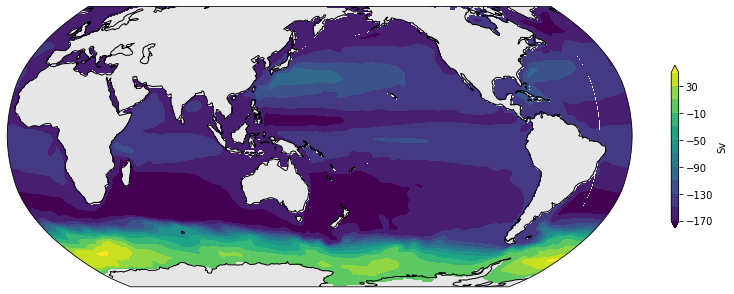

In [116]:
fig

## Antarctic Circumpolar Current

In [117]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 9))
ax = plt.axes(projection=ccrs.SouthPolarStereo(), facecolor='0.9')
ax.coastlines()

clevels = np.arange(-190, 51, 10)

Psi_bt.sel(lat_g=slice(None, -20)).mean('time').plot.contourf(levels=clevels, ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5, 'label': 'Sv'})
ax.set_extent((0, 360, -90, -40), crs=ccrs.PlateCarree())
plt.close()

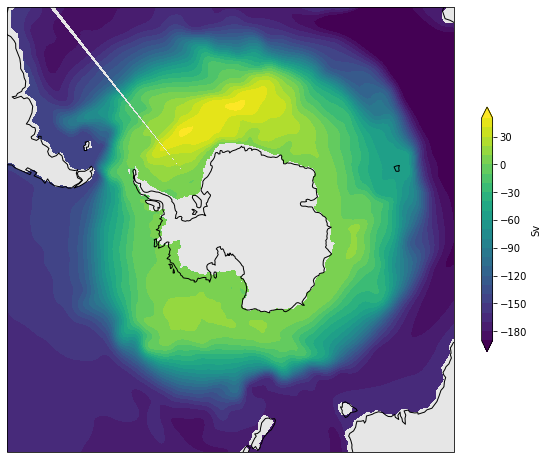

In [118]:
fig

### Drake Passage Transport

In [119]:
Psi_Drake_Passage = Psi_bt.sel(lon_g=290, method='nearest').sel(lat_g=slice(-70, -55))
Psi_Drake_Passage.plot.contourf(x='time', levels=np.arange(-180, 1, 20), cmap='viridis')
plt.close()

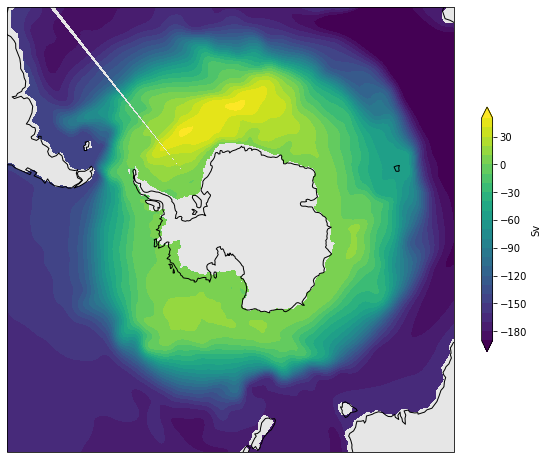

In [120]:
fig

In [121]:
(-Psi_Drake_Passage[:, -2]).plot()
plt.grid()
plt.title('ECCO Drake Passage Transport')
plt.close()

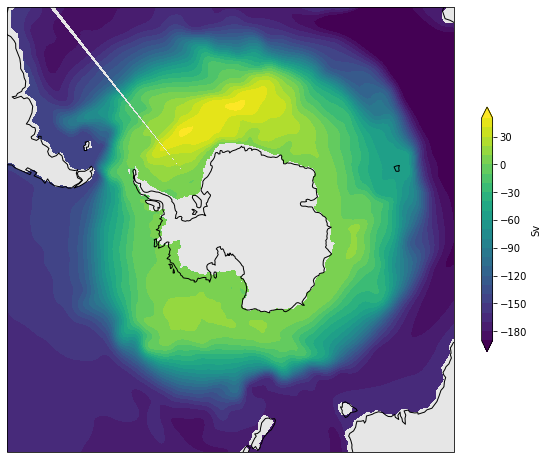

In [123]:
fig

## North Pacific Gyre



In [124]:
fig = plt.figure(figsize=(16, 6))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=190), facecolor='0.9')
ax.coastlines()

Psi_npac = Psi_bt.sel(lat_g=slice(10, 62), lon_g=slice(110, 260))
Psi_npac.mean('time').plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree())
ax.set_extent((120, 250, 15, 62), crs=ccrs.PlateCarree())
plt.close()

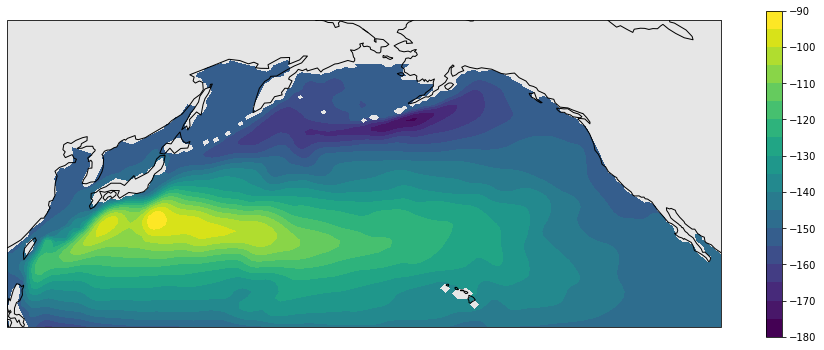

In [125]:
fig

- Large Subtropical gyre w/ Kuroshio western boundary current
- Smaller Subpolar gyre with Oyashio western boundary current
- North Equatorial Current

### Seasonality

The North Pacific Gyre has a strong seasonal cycle.

In [126]:
Psi_npac_mm = Psi_npac.groupby('time.month').mean('time')
Psi_npac_mm_anom = Psi_npac_mm - Psi_npac_mm.mean('month')


subplot_kws = dict(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=190), facecolor='0.9')
#ax.coastlines()

fg = Psi_npac_mm_anom.sel(month=slice(None, None, 3)).plot.contourf(
    levels=20, transform=ccrs.PlateCarree(), col='month', col_wrap=2, subplot_kws=subplot_kws,
    cbar_kwargs={'shrink': 0.5},
    figsize=(18, 8)
)
for ax in fg.axes.ravel():
    ax.set_extent((120, 250, 15, 62), crs=ccrs.PlateCarree())
    ax.coastlines()
plt.close()

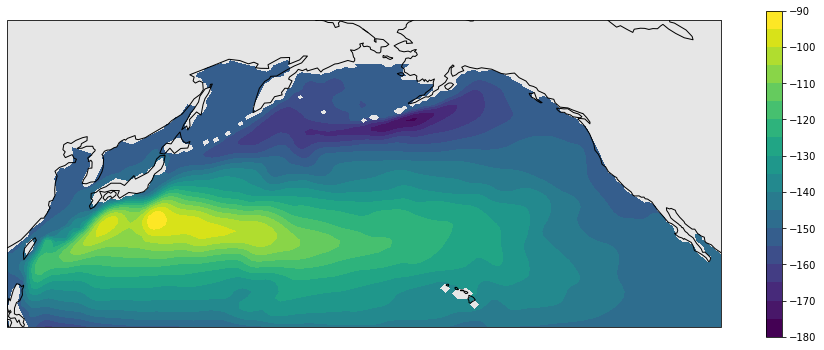

In [127]:
fig